In [2]:
import pandas as pd
# from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
import pandas as pd
df = pd.read_csv("district_mobility_cases.csv")#.dropna()
# df[df['Confirmed']<0] = np.nan
# df[df['Confirmed']] = df[df['Confirmed']].interpolate()
df.info()

import sklearn
from sklearn.preprocessing import StandardScaler

# df[df.State=='West Bengal'].District.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181658 entries, 0 to 181657
Data columns (total 10 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   District                                            181658 non-null  object 
 1   Date                                                181658 non-null  object 
 2   retail_and_recreation_percent_change_from_baseline  167731 non-null  float64
 3   grocery_and_pharmacy_percent_change_from_baseline   154821 non-null  float64
 4   parks_percent_change_from_baseline                  169506 non-null  float64
 5   transit_stations_percent_change_from_baseline       173456 non-null  float64
 6   workplaces_percent_change_from_baseline             180672 non-null  float64
 7   residential_percent_change_from_baseline            172356 non-null  float64
 8   State                                               181658 non-n

In [121]:
# !wget https://covid.ourworldindata.org/data/owid-covid-data.csv
applemobility = pd.read_csv("/content/applemobilitytrends-2021-04-24.csv")
applemobility = applemobility[applemobility['region']=='India']
applemobility = applemobility.drop(['geo_type','sub-region','country','alternative_name'],axis=1)
applemobility
applemobility = applemobility.melt(id_vars=['region','transportation_type'],var_name='Date',value_name='mobility')
applemobility.columns = ['location','transport','date','mobility']
applemobility['date'] = pd.to_datetime(applemobility['date'])
# applemobility = pd.pivot_table(applemobility, 'transport', )
# applemobility = applemobility.groupby('transport')

# applemobility['date'] = pd.to_datetime(applemobility['date'])
new_df = applemobility[applemobility['transport']=='walking'].reset_index()
new_df['transport/driving'] = applemobility[applemobility['transport']=='driving']['mobility'].values#.reset_index()
applemobility = new_df.drop(['index','transport'], axis=1)
# applemobility
# dfs = [gb.get_group(x) for x in applemobility.groupby('transport').groups]
# applemobility[]
applemobility.columns = ['location','date','walking','driving']

# applemobility.date = (applemobility.date - applemobility.date.min()).astype('timedelta64[D]')
df2 = pd.merge(applemobility.drop('location',axis=1), india_cases, on=['date']).dropna()
df2.date = (df2.date - df2.date.min()).astype('timedelta64[D]')
df2
# applemobility
# new_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,walking,driving,new_cases
0,0.0,110.41,115.40,1.0
1,1.0,117.08,122.46,0.0
2,2.0,125.96,131.49,0.0
3,3.0,113.76,119.28,1.0
4,4.0,110.57,108.72,1.0
...,...,...,...,...
446,446.0,86.89,75.51,295158.0
447,447.0,86.65,76.82,314644.0
448,448.0,85.11,75.81,332921.0
449,449.0,80.09,72.17,346786.0


In [9]:
df

,District,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,State,Confirmed
0,Chittoor,2020-04-26,-83.0,-48.0,-57.0,-68.0,-33.0,23.0,Andhra Pradesh,0.0
1,Chittoor,2020-04-27,-83.0,-46.0,-50.0,-67.0,-50.0,31.0,Andhra Pradesh,0.0
2,Chittoor,2020-04-28,-83.0,-46.0,-48.0,-65.0,-52.0,29.0,Andhra Pradesh,1.0
3,Chittoor,2020-04-29,-82.0,-44.0,-49.0,-64.0,-52.0,28.0,Andhra Pradesh,3.0
4,Chittoor,2020-04-30,-83.0,-41.0,-49.0,-65.0,-51.0,29.0,Andhra Pradesh,3.0
...,...,...,...,...,...,...,...,...,...,...
181653,Uttar Dinajpur,2021-04-10,-6.0,33.0,1.0,-12.0,-7.0,12.0,West Bengal,50.0
181654,Uttar Dinajpur,2021-04-11,-2.0,35.0,7.0,-10.0,-2.0,11.0,West Bengal,26.0
181655,Uttar Dinajpur,2021-04-12,-2.0,37.0,8.0,-8.0,-6.0,10.0,West Bengal,73.0
181656,Uttar Dinajpur,2021-04-13,2.0,41.0,8.0,-2.0,-10.0,10.0,West Bengal,78.0


In [36]:
from statsmodels.tsa.api import VAR

data = df[df['State']=='West Bengal'][['Confirmed','Date','District']].dropna()

# data['date'] = 
# print(df2.info())
# cols = ['driving','walking','new_cases']

data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = (data['Date'] - data['Date'].min()).astype('timedelta64[D]')

# data = data[data['date']<90]

def get_data(data, districts):
    fdata = []
    lowLen = float('inf')
    for district in districts:
        vals = data[data['District']==district]['Confirmed'].values
        if vals.size < lowLen:
            lowLen = vals.size

        fdata.append(vals)

    ndata = []
    for i in range(len(fdata)):
        ndata.append(fdata[i][-lowLen:])


    return np.asarray(ndata)

districts = data['District'].unique().tolist()
fdata = get_data(data, districts)


# data.loc[:,mobility] = data.loc[:,mobility].shift(7)
# df = data.dropna()
# print(df2.info())
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# data.loc[:,cols] = scaler.fit_transform(data.loc[:,'Confi'])


fdata = scaler.fit_transform(fdata)
print(fdata.shape)
fdata = pd.DataFrame(fdata.T)
fdata.columns = districts
model = VAR(fdata)#, data['Date'].values)
results = model.fit()
results.summary()

# for mobility in data.columns[:-1]:
for t in districts:
    print(results.test_causality([t],['Kolkata'], kind='f').summary())
# print(results.test_causality(['Howrah'], ['Kolkata'], kind='wald').summary())
# print(results.test_causality(['South 24 Parganas'], ['Kolkata'], kind='wald').summary())
# 'Cooch Behar','Howrah','Malda','North 24 Parganas','Uttar Dinajpur','Murshidabad'

(18, 320)
Granger causality F-test. H_0: Kolkata does not Granger-cause Alipurduar. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         10.36          3.843   0.001 (1, 5400)
-----------------------------------------------
Granger causality F-test. H_0: Kolkata does not Granger-cause Bankura. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         13.01          3.843   0.000 (1, 5400)
-----------------------------------------------
Granger causality F-test. H_0: Kolkata does not Granger-cause Birbhum. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         4.946          3.843   0.026 (1, 5400)
-----------------------------------------------
Granger causality F-test. H_0: Kolkata does not Gra

In [27]:
df.size

1816580

In [126]:
df2

,date,walking,driving,new_cases
0,0.0,110.41,115.40,1.0
1,1.0,117.08,122.46,0.0
2,2.0,125.96,131.49,0.0
3,3.0,113.76,119.28,1.0
4,4.0,110.57,108.72,1.0
...,...,...,...,...
446,446.0,86.89,75.51,295158.0
447,447.0,86.65,76.82,314644.0
448,448.0,85.11,75.81,332921.0
449,449.0,80.09,72.17,346786.0


In [120]:
world = pd.read_csv("/content/owid-covid-data.csv")
india_cases = world[world['location']=='India'][['date','new_cases']]
india_cases['date'] = pd.to_datetime(india_cases['date'])
applemobility

,location,date,walking,driving
0,India,2020-01-13,100.00,100.00
1,India,2020-01-14,99.18,102.35
2,India,2020-01-15,104.08,107.96
3,India,2020-01-16,107.41,110.77
4,India,2020-01-17,113.91,120.64
...,...,...,...,...
463,India,2021-04-20,86.89,75.51
464,India,2021-04-21,86.65,76.82
465,India,2021-04-22,85.11,75.81
466,India,2021-04-23,80.09,72.17


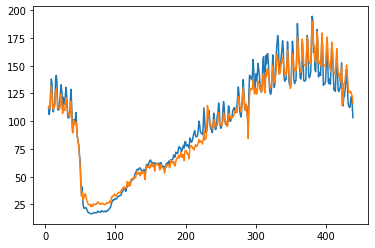

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


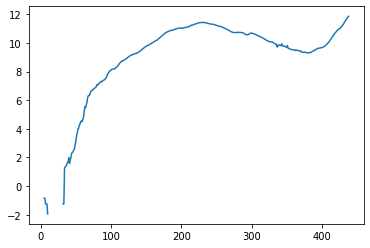

In [131]:
from sklearn.preprocessing import normalize
plt.plot(df2.driving)#.values.reshape(1,-1), label='Driving')
plt.plot(df2.walking)#.values.reshape(1,-1), label='Walking')
plt.show()
plt.cla()
plt.plot(np.log(df2.new_cases_smoothed), label='Cases')

In [ ]:
import pandas as pd
df = pd.read_csv("owid-covid-data.csv")
df.info()

df1 = df[['date','location','stringency_index','new_cases_smoothed']]
# df['stringency_index']
df1 = df1[df1['location']=='India'].reset_index()
df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.drop('index',axis=1)
# df1['date'] = (df1['date'] - df1['date'].min()).astype('timedelta64[D]')
# df1 = df1.dropna()
df1.info()
# df1[df1['stringency_index'].isnull()]# = df1['stringency']i
# df1.tail(25)
# df1['stringency_index'] = .min
# df1['stringency_index'].fillna(df1['stringency_index'].mean())

In [141]:
mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
cols = [*mobility, 'Confirmed_1','Confirmed_2','Confirmed_3']#,'Confirmed_4','Confirmed_5','Confirmed_6','Confirmed_7']
confirmed_cols = ['Confirmed','Confirmed_1','Confirmed_2','Confirmed_3']#,'Confirmed_4','Confirmed_5','Confirmed_6','Confirmed_7']

mumbai = df[df['District']=='Kolkata'].copy().reset_index()

mumbai['Confirmed_1'] = mumbai['Confirmed'].shift(-1)
mumbai['Confirmed_2'] = mumbai['Confirmed'].shift(-2)
mumbai['Confirmed_3'] = mumbai['Confirmed'].shift(-3)
# mumbai['Confirmed_4'] = mumbai['Confirmed'].shift(-4)
# mumbai['Confirmed_5'] = mumbai['Confirmed'].shift(-5)
# mumbai['Confirmed_6'] = mumbai['Confirmed'].shift(-6)
# mumbai['Confirmed_7'] = mumbai['Confirmed'].shift(-7)

mumbai.loc[:,mobility] = mumbai[mobility].shift(14)

mumbai = mumbai.dropna()

mask = np.random.rand(len(mumbai)) < 1.0

df_train = mumbai[mask].copy()
# df_test = mumbai[~mask].copy()

# df_train.loc[:,mobility] = df_train.loc[:,mobility].shift(10)
# df_test.loc[:,mobility] = df_test.loc[:,mobility].shift(10)

scaler = StandardScaler()
df_train.loc[:,mobility] = scaler.fit_transform(df_train[mobility])
# df_test.loc[:,mobility] = scaler.transform(df_test[mobility])

cases_scaler = StandardScaler()
cases_scaler.fit(df_train['Confirmed'].values.reshape(-1,1))
# df_train.loc[:,confirmed_cols] = cases_scaler.transform(df_train[confirmed_cols])

# df_test.loc[:,confirmed_cols] = cases_scaler.transform(df_test[confirmed_cols])
df_train.loc[:,confirmed_cols] = np.log(df_train.loc[:,confirmed_cols] + 1e-8)
# df_test.loc[:,confirmed_cols] = np.log(df_test.loc[:,confirmed_cols] + 1e-8)

xtrain = df_train[cols]
ytrain = df_train['Confirmed']

# xtest = df_test[cols]
# ytest = df_test['Confirmed']

xtrain[[i for i in confirmed_cols if i is not 'Confirmed']].head(), ytrain.head()

poisson_training_results = sm.GLM(ytrain, xtrain, family=sm.families.Poisson()).fit()



(    Confirmed_1  Confirmed_2  Confirmed_3
 14     3.988984     3.663562     4.442651
 15     3.663562     4.442651     3.433987
 16     4.442651     3.433987     3.761200
 17     3.433987     3.761200     4.174387
 18     3.761200     4.174387     3.828641, 14    3.610918
 15    3.988984
 16    3.663562
 17    4.442651
 18    3.433987
 Name: Confirmed, dtype: float64)

In [142]:
import statsmodels.api as sm

poisson_training_results = sm.GLM(ytrain, xtrain, family=sm.families.Poisson()).fit()
poisson_predictions = poisson_training_results.get_prediction(xtest)
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame['Actual'] = ytest
predictions_summary_frame['mean'] = predictions_summary_frame['mean']

poisson_training_results = sm.GLM(ytrain, xtrain, family=sm.families.NegativeBinomial()).fit()
poisson_predictions = poisson_training_results.get_prediction(xtest)
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame['Actual'] = ytest
predictions_summary_frame['mean'] = predictions_summary_frame['mean']
# print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Confirmed   No. Observations:                  337
Model:                            GLM   Df Residuals:                      328
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -609.84
Date:                Thu, 29 Apr 2021   Deviance:                       14.923
Time:                        02:09:29   Pearson chi2:                     15.2
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [71]:
poisson_predictions = poisson_training_results.get_prediction(xtest)
predictions_summary_frame = poisson_predictions.summary_frame()
# predictions_summary_frame['Actual'] = cases_scaler.inverse_transform(ytest)
# predictions_summary_frame['mean'] = cases_scaler.inverse_transform(predictions_summary_frame['mean']).astype(int)
predictions_summary_frame['Actual'] = np.exp(ytest)
predictions_summary_frame['mean'] = np.exp(predictions_summary_frame['mean']).astype(int)


print(predictions_summary_frame)


     mean   mean_se  mean_ci_lower  mean_ci_upper  Actual
15    343  0.795034       4.472028       7.625620   782.0
19    772  0.753277       5.325481       8.302592   933.0
23    800  0.633769       5.552112       8.050759  1411.0
26   1330  0.621543       6.072436       8.520502  1751.0
27   1305  0.692395       5.937536       8.667893  1566.0
..    ...       ...            ...            ...     ...
298   514  0.433958       5.448349       7.154700   643.0
303   351  0.531151       4.907047       7.000086  1051.0
308   866  0.443972       5.947635       7.692779  1174.0
310   399  0.526812       5.041459       7.116766  1361.0
316  1513  0.492590       6.417737       8.354254  1709.0

[69 rows x 5 columns]


In [72]:
np.mean(abs(predictions_summary_frame['mean'].values - ytest))

1183.1685878483886

In [144]:
## Autoregressive

poisson_training_results = sm.GLM(ytrain, xtrain, family=sm.families.NegativeBinomial()).fit()

print(poisson_training_results.summary())

# previous_days, forecast_days = 14, 7
# total = mumbai.shape[0]
# test_sample_nos = 8
# test_idx = np.random.randint(0,total,10).tolist()
# test_idx = [29,59,94,]

# test_indices = [np.arange(i,i+21) for i in test_idx]
# flattened_test_indices = [i for j in test_indices for i in j]
# train_indices = []
# last = True
# for i in range(total):
#     if i in flattened_test_indices:
#         if last is False:
#             train_indices.append(new)
#         last = True
#         continue
#     else:
#         if last:
#             new = [i]
#             last = False
#         else:
#             new.append(i)


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Confirmed   No. Observations:                  337
Model:                            GLM   Df Residuals:                      328
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -942.60
Date:                Thu, 29 Apr 2021   Deviance:                       2.4036
Time:                        02:11:19   Pearson chi2:                     2.44
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

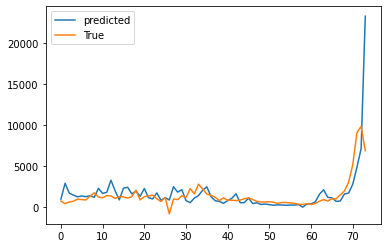

In [23]:
plt.plot(np.arange(0,74),poisson_predictions.summary_frame()['mean'].values, label='predicted')
plt.plot(np.arange(0,74),ytest, label='True')
plt.legend()

In [169]:
from scipy.signal import savgol_filter

def smoothen_data(data):
    return savgol_filter(data, 51, 3)

df.groupby('Date')

In [ ]:
districts = df.District.unique()
df.dropna
all = []
for district in districts:
    print(df[df.District==district]['Confirmed'].shape)
    cases = smoothen_data(df[df.District==district]['Confirmed'].values)
    cases = np.log(cases)
    # print(cases.shape)
    all.append(cases)

np.asarray(all).shape

In [195]:
# pd.get_dummies(df.District)#.reindex(columns=df, fill_value=0)
timeseriess = pd.pivot_table(df, index=df['Date'], columns=df.District, values='Confirmed')#.values
timeseriess = timeseriess.rolling(window=2).mean()
timeseriess = timeseriess[timeseriess.select_dtypes(include=[np.number]).ge(0).all(1)]
timeseriess.replace([np.inf, -np.inf], np.nan, inplace=True)
# timeseriess.columns

In [33]:
df1 = pd.read_csv("/content/owid-covid-data.csv")
df1.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [40]:
df1[df1['location']=='India'][['stringency_index','new_cases','date']]

,stringency_index,new_cases,date
34928,10.19,1.0,2020-01-30
34929,10.19,0.0,2020-01-31
34930,10.19,0.0,2020-02-01
34931,10.19,1.0,2020-02-02
34932,10.19,1.0,2020-02-03
...,...,...,...
35379,NaN,352991.0,2021-04-25
35380,NaN,323023.0,2021-04-26
35381,NaN,360927.0,2021-04-27
35382,NaN,379308.0,2021-04-28


In [45]:
from statsmodels.tsa.api import VAR

data = df1[df1['location']=='India'][['stringency_index','new_cases','date']]
# data['date'] = 
print(data.info())
cols = ['stringency_index','new_cases']

# data['Confirmed_1'] = data['Confirmed'].shift(-1)
# mobility = data.columns[:-2]
data['date'] = pd.to_datetime(data['date'])
data['date'] = (data['date'] - data['date'].min()).astype('timedelta64[D]')
data = data[data['date']<90]

# data.loc[:,mobility] = data.loc[:,mobility].shift(7)
data = data.dropna()
print(data.info())
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data.loc[:,cols] = scaler.fit_transform(data.loc[:,cols])
model = VAR(data[cols])#, data['Date'].values)
results = model.fit()
results.summary()

# for mobility in data.columns[:-1]:
print(results.test_causality(['new_cases'], ['stringency_index'], kind='f').summary())
# print(results.test_causality(['Howrah'], ['Kolkata'], kind='wald').summary())
# print(results.test_causality(['South 24 Parganas'], ['Kolkata'], kind='wald').summary())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 34928 to 35383
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stringency_index  439 non-null    float64
 1   new_cases         456 non-null    float64
 2   date              456 non-null    object 
dtypes: float64(2), object(1)
memory usage: 14.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 34928 to 35017
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stringency_index  90 non-null     float64
 1   new_cases         90 non-null     float64
 2   date              90 non-null     float64
dtypes: float64(3)
memory usage: 2.8 KB
None
Granger causality F-test. H_0: stringency_index does not Granger-cause new_cases. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [108]:
from statsmodels.tsa.api import VAR
data = df1[df1['location']=='India'][['stringency_index','new_cases','date']]
    # data['date'] = 
cols = ['stringency_index','new_cases']

# data['Confirmed_1'] = data['Confirmed'].shift(-1)
# mobility = data.columns[:-2]
data['date'] = pd.to_datetime(data['date'])
# data = data.iloc[data['stringency_index'].values!=0.,:]
data['date'] = (data['date'] - data['date'].min()).astype('timedelta64[D]')
# print(data.info())


for i in [90,180,270,360,450]:
    data1 = data[(data['date']>(i-90)) & (data['date']<i)]
    # print(data1.info())

    # data.loc[:,mobility] = data.loc[:,mobility].shift(7)
    data1 = data1.dropna()

    from sklearn.preprocessing import MinMaxScaler
    # scaler = StandardScaler()
    # data1.loc[:,cols] = scaler.fit_transform(data1.loc[:,cols])
    model = VAR(data1[cols])#, data['Date'].values)
    results = model.fit()
    results.summary()

    # for mobility in data.columns[:-1]:
    print(f"{i-90} to {i}", results.test_causality(['new_cases'], ['stringency_index'], kind='f').summary())
# print(results.test_causality(['Howrah'], ['Kolkata'], kind='wald').summary())
# print(results.test_causality(['South 24 Parganas'], ['Kolkata'], kind='wald').summary())

0 to 90 Granger causality F-test. H_0: stringency_index does not Granger-cause new_cases. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.215          3.897   0.024 (1, 170)
----------------------------------------------
90 to 180 Granger causality F-test. H_0: stringency_index does not Granger-cause new_cases. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
       0.06183          3.897   0.804 (1, 170)
----------------------------------------------
180 to 270 Granger causality F-test. H_0: stringency_index does not Granger-cause new_cases. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.622          3.897   0.011 (1, 170)
----------------------------------------------
270 to

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

In [104]:
# data.stringency_index.values != 0.0#,:]
df1[df1['location']=='India'][['stringency_index','new_cases','date']].dropna()

,stringency_index,new_cases,date
34928,10.19,1.0,2020-01-30
34929,10.19,0.0,2020-01-31
34930,10.19,0.0,2020-02-01
34931,10.19,1.0,2020-02-02
34932,10.19,1.0,2020-02-03
...,...,...,...
35362,69.91,131968.0,2021-04-08
35363,69.91,145384.0,2021-04-09
35364,69.91,152879.0,2021-04-10
35365,69.91,168912.0,2021-04-11


# 100 to 200: 0.29
# 200 to 250: 0.084

# 400 onwards: 0.79

In [280]:
# timeseriess.replace([np.inf, -np.inf], np.nan, inplace=True)

# timeseriess.isna().any().any()
# timeseriess.isna()
# timeseriess
# sum(timeseriess.values == -np.inf)
# cols = timeseriess.columns[:200]
# timeseriess[timeseriess > 1000]
cols = (timeseriess.astype(int) > 500).any().tolist()
cols = timeseriess.loc[:,cols].columns
cols[:5]

cols = ['North 24 Parganas','Kolkata','Howrah','South 24 Parganas']


In [110]:
mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

In [113]:
from statsmodels.tsa.api import VAR

data = df[df['District']=='Mumbai'][['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Confirmed','Date']]

cols = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Confirmed']

# data['Confirmed_1'] = data['Confirmed'].shift(-1)
mobility = data.columns[:-2]
data['Date'] = pd.to_datetime(data['Date'])

data.loc[:,mobility] = data.loc[:,mobility].shift(7)
data = data.dropna()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# data.loc[:,cols] = scaler.fit_transform(data.loc[:,cols])
model = VAR(data[cols])#, data['Date'].values)
results = model.fit()
results.summary()

for mobility in data.columns[:-1]:
    print(results.test_causality(['Confirmed'], [mobility], kind='f').summary())
# print(results.test_causality(['Howrah'], ['Kolkata'], kind='wald').summary())
# print(results.test_causality(['South 24 Parganas'], ['Kolkata'], kind='wald').summary())

Granger causality F-test. H_0: retail_and_recreation_percent_change_from_baseline does not Granger-cause Confirmed. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.276          3.845   0.259 (1, 2366)
-----------------------------------------------
Granger causality F-test. H_0: grocery_and_pharmacy_percent_change_from_baseline does not Granger-cause Confirmed. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         5.548          3.845   0.019 (1, 2366)
-----------------------------------------------
Granger causality F-test. H_0: parks_percent_change_from_baseline does not Granger-cause Confirmed. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.136          3.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [23]:
# data[cols]
import pandas as pd
df = pd.read_csv("")

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Confirmed
64893,0.000000,0.061856,0.000000,0.054545,0.243243,0.606061,0.717404
64894,0.035714,0.072165,0.000000,0.018182,0.027027,0.939394,0.754019
64895,0.017857,0.061856,0.000000,0.018182,0.027027,0.969697,0.756400
64896,0.035714,0.072165,0.000000,0.036364,0.027027,0.909091,0.764537
64897,0.035714,0.082474,0.035714,0.018182,0.027027,0.939394,0.758782
...,...,...,...,...,...,...,...
65138,0.803571,0.608247,0.892857,0.945455,1.000000,0.000000,0.774757
65139,0.910714,0.721649,0.946429,0.890909,0.689189,0.181818,0.772673
65140,0.892857,0.721649,1.000000,0.872727,0.702703,0.212121,0.770689
65141,0.910714,0.783505,1.000000,0.927273,0.743243,0.151515,0.788252


In [281]:
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
timeseriess.loc[:,cols] = scaler.fit_transform(timeseriess.loc[:,cols])
model = VAR(timeseriess.loc[:,cols])
results = model.fit()
results.summary()
# cols#[:5]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Apr, 2021
Time:                     03:46:04
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.6567
Nobs:                     26.0000    HQIC:                  -27.3458
Log likelihood:           231.549    FPE:                1.02624e-12
AIC:                     -27.6245    Det(Omega_mle):     5.07806e-13
--------------------------------------------------------------------
Results for equation North 24 Parganas
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000783         0.009917            0.079           0.937
L1.North 24 Parganas         0.703187         0.235994            2.980           0.003
L1.Kolkata          

In [286]:
# results = model.fit(maxlags=15, ic='aic')
print(results.test_causality(['North 24 Parganas'], ['Kolkata'], kind='wald').summary())
print(results.test_causality(['Howrah'], ['Kolkata'], kind='wald').summary())
print(results.test_causality(['South 24 Parganas'], ['Kolkata'], kind='wald').summary())

Granger causality Wald-test. H_0: Kolkata does not Granger-cause North 24 Parganas. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         3.649          3.841   0.056  1
----------------------------------------
Granger causality Wald-test. H_0: Kolkata does not Granger-cause Howrah. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         24.74          3.841   0.000  1
----------------------------------------
Granger causality Wald-test. H_0: Kolkata does not Granger-cause South 24 Parganas. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         4.043          3.841   0.044  1
----------------------------------------


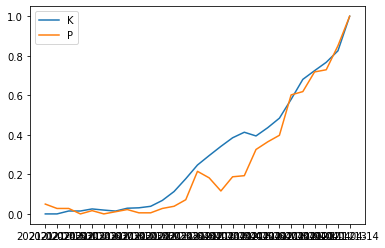

In [260]:
# plt.plot(timeseriess['Mumbai'],label='M')
def normalize(data):
    return (data - data.min())/(data.max() - data.min())
data1 = timeseriess['Kolkata']
data2 = timeseriess['Purba Medinipur']
plt.plot((data1-data1.min())/(data1.max()-data1.min()),label='K')
plt.plot((data2-data2.min())/(data2.max()-data2.min()),label='P')
plt.legend()

In [143]:
# sm.add_constant(data.exog, prepend=False)
poisson_training_results = sm.GLM(ytrain, xtrain, family=sm.families.NegativeBinomial()).fit()

print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Confirmed   No. Observations:                  337
Model:                            GLM   Df Residuals:                      328
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -942.60
Date:                Thu, 29 Apr 2021   Deviance:                       2.4036
Time:                        02:10:07   Pearson chi2:                     2.44
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [54]:
poisson_predictions = poisson_training_results.get_prediction(xtest)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
# print(predictions_summary_frame)
predictions_summary_frame['Actual'] = cases_scaler.inverse_transform(ytest)

predictions_summary_frame['mean'] = cases_scaler.inverse_transform(predictions_summary_frame['mean']).astype(int)
print(predictions_summary_frame)

        mean     mean_se  mean_ci_lower  mean_ci_upper   Actual
16      4614    0.701966       1.132359       4.075996    426.0
17      3347    0.425732       0.669397       2.458425    800.0
18      2849    0.301909       0.503344       1.766045    991.0
20      3221    0.314320       0.715460       2.002690    884.0
38      3201    0.268920       0.757616       1.846990   1276.0
..       ...         ...            ...            ...      ...
315     3051    0.232777       0.708480       1.648297   1647.0
323     4899    0.950245       1.057849       5.187728   2982.0
332     1571    0.075694       0.008386       0.583358   5890.0
336   285272  140.976505      46.608503     806.292436   8948.0
338  1467024  639.403004     286.276896    3500.607579  11206.0

[62 rows x 5 columns]


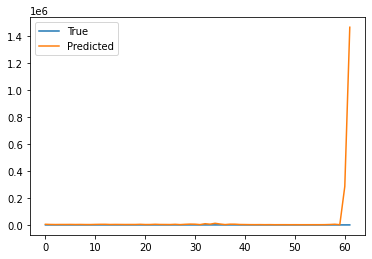

In [56]:
plt.plot(np.arange(0,62),ytest, label='True')
plt.plot(np.arange(0,62),predictions_summary_frame['mean'], label='Predicted')
plt.legend()

In [101]:
mask = np.random.rand(len(df)) < 0.8

In [195]:
# df = pd.read_csv("district_mobility_cases.csv").dropna()
# df = df[df['Confirmed']>=0]
mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

df['Confirmed_1'] = df['Confirmed'].shift(-1)
df['Confirmed_2'] = df['Confirmed'].shift(-2)

df[mobility] = df[mobility]
df_train = df[mask]
df_test = df[~mask]

xtrain = df_train[df_train['District']=='Mumbai'][['Confirmed_1','Confirmed_2']]
ytrain = df_train[df_train['District']=='Mumbai']['Confirmed']

xtest = df_test[df_test['District']=='Mumbai'][['Confirmed_1','Confirmed_2']]
ytest = df_test[df_test['District']=='Mumbai']['Confirmed']

bs = BSplines(xtrain, df=[1,1], degree=[0,0])

# strikes_data['Confirmed_adj'] = np.maximum(1, strikes_data['strikes'])


In [196]:
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import GLMGam, BSplines

training_results = sm.GLMGam(ytrain, xtrain, smoother=bs, alpha=[1,1], family=sm.families.NegativeBinomial()).fit()

# print(training_results.summary())

predictions = training_results.get_prediction(xtest, transform=True)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = predictions.summary_frame()
predictions_summary_frame['Actual'] = ytest
print(predictions_summary_frame)

sum((predictions_summary_frame['Actual'].values - predictions_summary_frame['mean'].values)**2)/predictions_summary_frame.shape[0]

                mean       mean_se  mean_ci_lower  mean_ci_upper  Actual
64906   9.014716e+02  1.898779e+01   8.650139e+02   9.394659e+02   722.0
64910   2.552082e+03  5.969125e+01   2.437730e+03   2.671798e+03   800.0
64916   6.785242e+04  2.236481e+03   6.360759e+04   7.238053e+04  1411.0
64934   7.059802e+04  2.376405e+03   6.609067e+04   7.541277e+04  1274.0
64936   1.849608e+04  1.019204e+03   1.660257e+04   2.060554e+04  1311.0
...              ...           ...            ...            ...     ...
154904  2.134700e+07  1.366770e+06   1.882944e+07   2.420116e+07  1713.0
154906  2.194864e+10  1.601123e+09   1.902452e+10   2.532221e+10  2377.0
154908  3.071561e+11  3.218570e+10   2.501296e+11   3.771840e+11  3063.0
154914  1.420578e+20  2.116738e+19   1.060795e+20   1.902386e+20  5505.0
154929  4.017509e+33  9.569937e+32   2.518812e+33   6.407932e+33  9202.0

[66 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/statsmodels/gam/generalized_additive_model.py:431: RuntimeWarning: invalid value encountered in sqrt
  wexog = np.sqrt(weights)[:, None] * self.model.exog


2.4455115070690003e+65

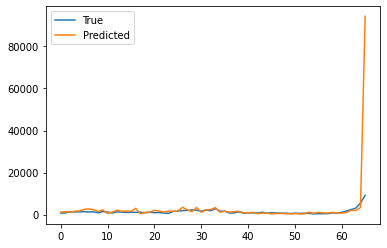

In [110]:
plt.plot(np.arange(0,66),ytest, label='True')
plt.plot(np.arange(0,66),predictions_summary_frame['mean'], label='Predicted')
plt.legend()

Negative Binomial Regression

In [207]:
df = pd.read_csv("district_mobility_cases.csv").dropna()
df = df[df['Confirmed']>=0]
mask = np.random.rand(len(df)) < 0.8
mobility = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

# df['Confirmed_1'] = df['Confirmed'].shift(-1)

df[mobility] = df[mobility]
df_train = df[mask]
df_test = df[~mask]

# xtrain = df_train[df_train['District']=='Mumbai'][mobility + ['Confirmed_1']]
# ytrain = df_train[df_train['District']=='Mumbai']['Confirmed']

# xtest = df_test[df_test['District']=='Mumbai'][mobility + ['Confirmed_1']]
# ytest = df_test[df_test['District']=='Mumbai']['Confirmed']

bs = BSplines(xtrain, df=[1,1,1,1,1,1, 1], degree=[0,0,0,0,0,0, 0])

df['Confirmed_adj'] = np.maximum(1, df['Confirmed'])

def indicator_func(x):
    if x == 0:
        return 1
    else:
        return 0

df['d'] = df['Confirmed'].apply(indicator_func)

df['ln_Confirmed_adj_lag1'] = df['Confirmed_adj'].shift(1)
df['ln_Confirmed_adj_lag2'] = df['Confirmed_adj'].shift(2)
df['ln_Confirmed_adj_lag3'] = df['Confirmed_adj'].shift(3)

df['d_lag1'] = df['d'].shift(1)
df['d_lag2'] = df['d'].shift(2)
df['d_lag3'] = df['d'].shift(3)

# df[mobility] = df[mobility].dropna()
df_train = df[mask].dropna()
df_test = df[~mask].dropna()

expr = 'Confirmed ~ ln_Confirmed_adj_lag1 + ln_Confirmed_adj_lag2 + ln_Confirmed_adj_lag3 + d_lag1 + d_lag2 + d_lag3'

In [209]:
import statsmodels.discrete.discrete_model as dm
from patsy import dmatrices

# expr = 'Confirmed ~ Confirmed_1'

# df_train = df_train[df_train['Confirmed_1']>=0]
# df_train = df_train[df_train['Confirmed']>=0]

# df_test = df_test[df_test['Confirmed_1']>=0]
# df_test = df_test[df_test['Confirmed']>=0]



# xtrain = df_train[df_train['District']=='Mumbai']['Confirmed_1']
# ytrain = df_train[df_train['District']=='Mumbai']['Confirmed']

# xtest = df_test[df_test['District']=='Mumbai']['Confirmed_1']
# ytest = df_test[df_test['District']=='Mumbai']['Confirmed']

y_train, X_train = dmatrices(expr, df_train[df_train['District']=='Ahmedabad'], return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test[df_test['District']=='Ahmedabad'], return_type='dataframe')

from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.api import GLMGam, BSplines
bs = BSplines(X_train, df=[1,1,1,1,1,1,1], degree=[0,0,0,0,0,0,0])

training_results = sm.GLMGam(y_train, X_train, smoother=bs, alpha=[1,1,1,1,1,1,1], family=sm.families.NegativeBinomial()).fit()

print(training_results.summary())

predictions = training_results.get_prediction(X_test, transform=True)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = predictions.summary_frame()
predictions_summary_frame['Actual'] = y_test.values
print(predictions_summary_frame)

sum((predictions_summary_frame['Actual'].values - predictions_summary_frame['mean'].values)**2)/predictions_summary_frame.shape[0]

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Confirmed   No. Observations:                  283
Model:                         GLMGam   Df Residuals:                   275.99
Model Family:        NegativeBinomial   Df Model:                         6.01
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -1785.9
Date:                Mon, 26 Apr 2021   Deviance:                       31.875
Time:                        22:08:34   Pearson chi2:                     26.4
No. Iterations:                   206                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.53

30020661.15690495

In [204]:
y_test

,Confirmed
19911,267.0
19912,250.0
19913,274.0
19914,259.0
19924,265.0
...,...
135687,451.0
135690,514.0
135691,558.0
135699,629.0


In [184]:
# plt.plot(np.arange(0,y_test.shape[0]),ytest, label='True')
# plt.plot(np.arange(0,y_test.shape[0]),predictions_summary_frame['mean'], label='Predicted')
# plt.legend()

# nb2_model_results.predict([1000,1000,1000])
# X_test
df

,District,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,State,Confirmed,Confirmed_1,Confirmed_adj,d,ln_Confirmed_adj_lag1,ln_Confirmed_adj_lag2,ln_Confirmed_adj_lag3,d_lag1,d_lag2,d_lag3
0,Chittoor,2020-04-26,-83.0,-48.0,-57.0,-68.0,-33.0,23.0,Andhra Pradesh,0.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,Chittoor,2020-04-27,-83.0,-46.0,-50.0,-67.0,-50.0,31.0,Andhra Pradesh,0.0,1.0,1.0,1,1.0,NaN,NaN,1.0,NaN,NaN
2,Chittoor,2020-04-28,-83.0,-46.0,-48.0,-65.0,-52.0,29.0,Andhra Pradesh,1.0,3.0,1.0,0,1.0,1.0,NaN,1.0,1.0,NaN
3,Chittoor,2020-04-29,-82.0,-44.0,-49.0,-64.0,-52.0,28.0,Andhra Pradesh,3.0,3.0,3.0,0,1.0,1.0,1.0,0.0,1.0,1.0
4,Chittoor,2020-04-30,-83.0,-41.0,-49.0,-65.0,-51.0,29.0,Andhra Pradesh,3.0,0.0,3.0,0,3.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181653,Uttar Dinajpur,2021-04-10,-6.0,33.0,1.0,-12.0,-7.0,12.0,West Bengal,50.0,26.0,50.0,0,24.0,24.0,23.0,0.0,0.0,0.0
181654,Uttar Dinajpur,2021-04-11,-2.0,35.0,7.0,-10.0,-2.0,11.0,West Bengal,26.0,73.0,26.0,0,50.0,24.0,24.0,0.0,0.0,0.0
181655,Uttar Dinajpur,2021-04-12,-2.0,37.0,8.0,-8.0,-6.0,10.0,West Bengal,73.0,78.0,73.0,0,26.0,50.0,24.0,0.0,0.0,0.0
181656,Uttar Dinajpur,2021-04-13,2.0,41.0,8.0,-2.0,-10.0,10.0,West Bengal,78.0,80.0,78.0,0,73.0,26.0,50.0,0.0,0.0,0.0


In [ ]:
# set(df_train['District'].unique())
# df[df['Dis']=='Delhi']#['District'].unique()
# df['State'].unique()

In [41]:
# some example data
# In [1]: import numpy as np

# In [2]: import pandas

# In [3]: import statsmodels.api as sm

from statsmodels.tsa.api import VAR

mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

from statsmodels.tsa.base.datetools import dates_from_str

quarterly = dates_from_str(quarterly)

mdata = mdata[['realgdp','realcons','realinv']]

mdata.index = pd.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

# make a VAR model
model = VAR(data)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [127]:
# !pip install patsy

In [42]:
results = model.fit(2)

In [43]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Apr, 2021
Time:                     20:09:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

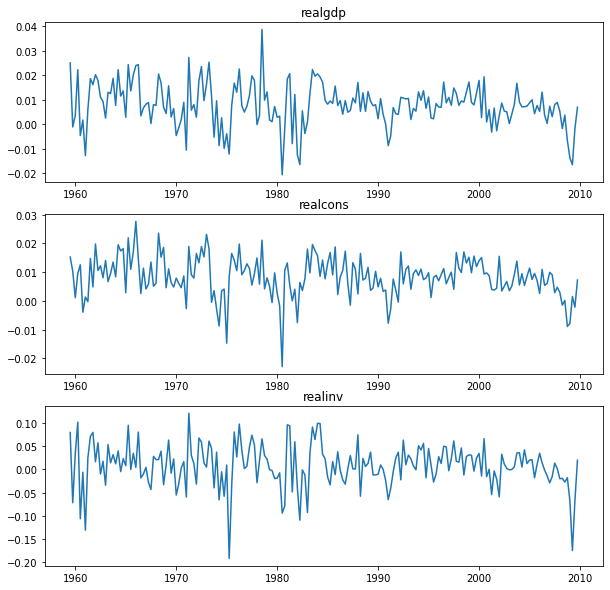

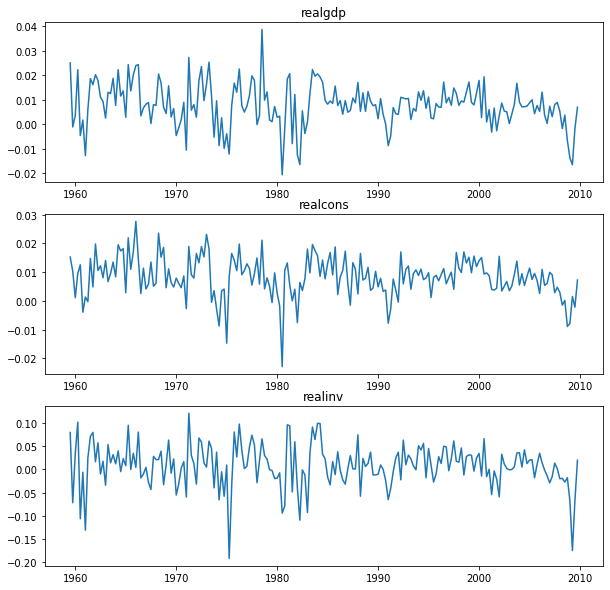

In [44]:
results.plot()

In [47]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f').summary()

Test statistic,Critical value,p-value,df
9.905,2.387,0.000,"(4, 579)"


In [52]:
# ytrain.astype(float), xtrain.values.astype(float)

(64893        0.0
 64894      369.0
 64895      393.0
 64896      475.0
 64897      417.0
            ...  
 154929    9202.0
 154930    9330.0
 154931    9986.0
 154933    7873.0
 154934    9931.0
 Name: Confirmed, Length: 280, dtype: float64,
 array([[  1., -94., -70., ..., -90., -69.,  25.],
        [  1., -92., -69., ..., -92., -85.,  36.],
        [  1., -93., -70., ..., -92., -85.,  37.],
        ...,
        [  1., -85., -51., ..., -72., -46.,  20.],
        [  1., -61.,  -2., ..., -57., -57.,  21.],
        [  1., -63.,   2., ..., -52., -51.,  18.]]))

In [55]:
(ytrain < 0).sum()

4